In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
num_epochs = 10
batch_size = 64

In [3]:
# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 전처리 및 변환
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 전체 훈련 데이터셋 로드
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 훈련 데이터셋을 80% 훈련용과 20% 검증용으로 분할
train_size = int(0.8 * len(full_train_dataset))
valid_size = len(full_train_dataset) - train_size
train_dataset, valid_dataset = random_split(full_train_dataset, [train_size, valid_size])

# 테스트 데이터셋 로드
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# 데이터로더 정의
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15090208.05it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 527555.42it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3536644.89it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5008025.44it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# 모델 정의
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         # 합성곱 층
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(2, 2)
#         # 완전 연결 층
#         self.fc1 = nn.Linear(64 * 14 * 14, 128)
#         self.fc2 = nn.Linear(128, 10)
#         # 활성화 함수와 드롭아웃
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.25)

#     def forward(self, x):
#         x = self.relu(self.conv1(x))   # [batch_size, 32, 28, 28]
#         x = self.relu(self.conv2(x))   # [batch_size, 64, 28, 28]
#         x = self.pool(x)               # [batch_size, 64, 14, 14]
#         x = self.dropout(x)
#         x = x.view(-1, 64 * 14 * 14)   # 평탄화
#         x = self.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)  # 입력 차원은 28x28 (이미지 크기)
        self.fc2 = nn.Linear(512, 256)    # 두 번째 히든 레이어
        self.fc3 = nn.Linear(256, 10)     # 출력 레이어 (10개의 클래스, 0~9 숫자)

    def forward(self, x):
        x = x.view(-1, 28*28)  # 입력 이미지를 1D 벡터로 변환
        x = F.relu(self.fc1(x))  # 첫 번째 레이어에 ReLU 적용
        x = F.relu(self.fc2(x))  # 두 번째 레이어에 ReLU 적용
        x = self.fc3(x)          # 출력 레이어
        return x

In [6]:
train_size/batch_size
#len(train_loader)

750.0

In [7]:
# 모델, 손실 함수, 옵티마이저 설정
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 및 검증 과정에서 손실과 정확도를 저장할 리스트 초기화
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

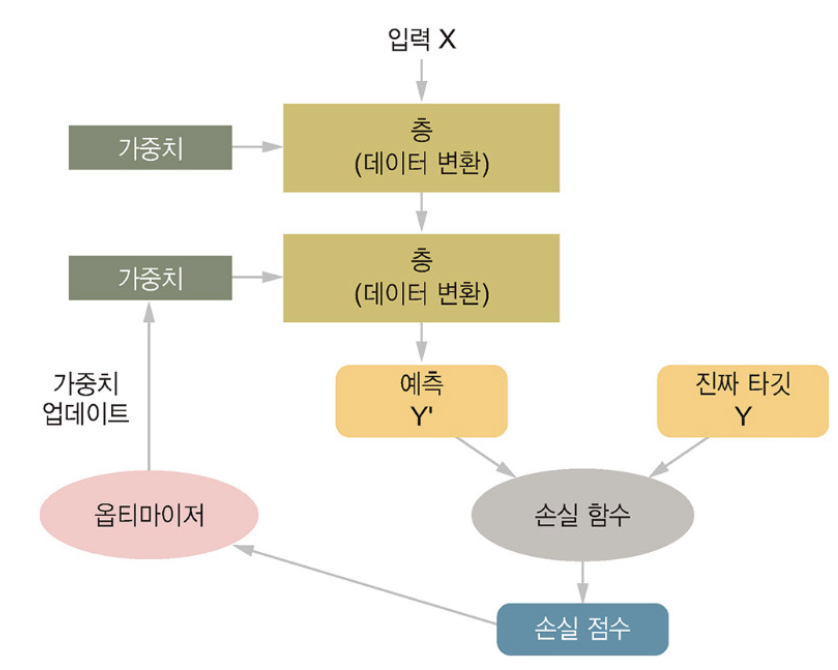

In [8]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    #print('\033[34m' + 'Training   ' + '\033[0m', end='')
    startStr = f'Epoch {epoch+1:2d}/{num_epochs} \033[34m' + 'Train ' + '\033[0m'
    with tqdm(total=len(train_loader), desc=startStr) as pbar:
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
            pbar.update(1)
        train_loss = train_loss / train_total
        train_accuracy = 100 * train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # 진행 바 끝날 때 메시지 수정
        str = f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.3f}%'
        pbar.set_postfix_str(str)

In [9]:
def valid_or_test(mode, model, device, dataloader):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        if mode == 'valid':
            startStr = f'Epoch {epoch+1:2d}/{num_epochs} \033[34m' + 'Valid ' + '\033[0m'
        elif mode == 'test':
            startStr = f'Epoch {epoch+1:2d}/{num_epochs} \033[34m' + 'Test ' + '\033[0m'

        with tqdm(total=len(dataloader), desc=startStr) as pbar:
        #print('\033[34m' + 'Validation ' + '\033[0m', end='')
            for data, target in dataloader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                loss = criterion(outputs, target)

                loss += loss.item() * data.size(0)
                _, predicted = torch.max(outputs, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
                pbar.update(1)

            loss = loss / total
            accuracy = 100 * correct / total
            if mode == 'valid':
                endStr = f'Valid Loss: {loss:.4f}, Valid Acc: {accuracy:.3f}%'
            elif mode == 'test':
                endStr = f'Test Loss: {loss:.4f}, Test Acc: {accuracy:.3f}%'
            pbar.set_postfix_str(endStr)

    if mode == 'valid':
        valid_losses.append(loss)
        valid_accuracies.append(accuracy)
        print('-'*110)

In [10]:
for epoch in range(num_epochs):
    train(model, device, train_loader, optimizer, epoch)
    valid_or_test('valid', model, device, valid_loader)


valid_or_test('test', model, device, test_loader)


Epoch  1/10 Valid : 100%|██████████| 188/188 [00:04<00:00, 38.38it/s, Valid Loss: 0.0004, Valid Acc: 95.508%]


--------------------------------------------------------------------------------------------------------------


Epoch  2/10 Valid : 100%|██████████| 188/188 [00:02<00:00, 72.59it/s, Valid Loss: 0.0002, Valid Acc: 96.808%]


--------------------------------------------------------------------------------------------------------------


Epoch  3/10 Valid : 100%|██████████| 188/188 [00:02<00:00, 70.11it/s, Valid Loss: 0.0001, Valid Acc: 97.325%]


--------------------------------------------------------------------------------------------------------------


Epoch  4/10 Valid : 100%|██████████| 188/188 [00:03<00:00, 59.18it/s, Valid Loss: 0.0000, Valid Acc: 97.392%]


--------------------------------------------------------------------------------------------------------------


Epoch  5/10 Valid : 100%|██████████| 188/188 [00:03<00:00, 60.83it/s, Valid Loss: 0.0000, Valid Acc: 97.508%]


--------------------------------------------------------------------------------------------------------------


Epoch  6/10 Valid : 100%|██████████| 188/188 [00:02<00:00, 64.30it/s, Valid Loss: 0.0000, Valid Acc: 97.508%]


--------------------------------------------------------------------------------------------------------------


Epoch  7/10 Valid : 100%|██████████| 188/188 [00:02<00:00, 68.27it/s, Valid Loss: 0.0001, Valid Acc: 97.633%]


--------------------------------------------------------------------------------------------------------------


Epoch  8/10 Valid : 100%|██████████| 188/188 [00:02<00:00, 64.43it/s, Valid Loss: 0.0003, Valid Acc: 97.817%]


--------------------------------------------------------------------------------------------------------------


Epoch  9/10 Valid : 100%|██████████| 188/188 [00:03<00:00, 59.78it/s, Valid Loss: 0.0000, Valid Acc: 97.583%]


--------------------------------------------------------------------------------------------------------------


Epoch 10/10 Valid : 100%|██████████| 188/188 [00:02<00:00, 71.58it/s, Valid Loss: 0.0000, Valid Acc: 97.825%]


--------------------------------------------------------------------------------------------------------------


Epoch 10/10 Test : 100%|██████████| 157/157 [00:02<00:00, 68.97it/s, Test Loss: 0.0000, Test Acc: 97.880%]


In [11]:
print(valid_losses)
# valid_losses의 device를 'cuda:0'에서 cpu로 변경
valid_losses = [loss.cpu().numpy() for loss in valid_losses]

[tensor(0.0004, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(6.6926e-05, device='cuda:0'), tensor(2.3228e-05, device='cuda:0'), tensor(1.0745e-05, device='cuda:0'), tensor(1.6870e-05, device='cuda:0'), tensor(5.1635e-05, device='cuda:0'), tensor(0.0003, device='cuda:0'), tensor(1.5748e-06, device='cuda:0'), tensor(9.3778e-06, device='cuda:0')]


In [12]:
train_losses, valid_losses

([0.22217067126184703,
  0.09439651593441764,
  0.06472605274959158,
  0.04923068704285349,
  0.04058623621279063,
  0.03248393485479755,
  0.02919821156652567,
  0.023537114075850695,
  0.026172551158927186,
  0.021121311521982232],
 [array(0.00043182, dtype=float32),
  array(0.00018892, dtype=float32),
  array(6.692603e-05, dtype=float32),
  array(2.3228442e-05, dtype=float32),
  array(1.0744907e-05, dtype=float32),
  array(1.6870074e-05, dtype=float32),
  array(5.1634986e-05, dtype=float32),
  array(0.00025923, dtype=float32),
  array(1.5747981e-06, dtype=float32),
  array(9.377848e-06, dtype=float32)])

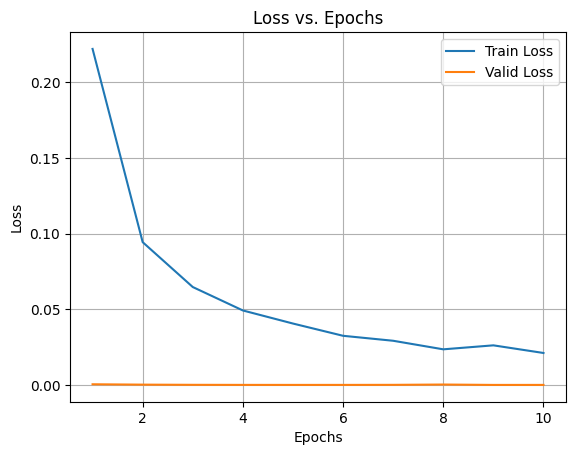

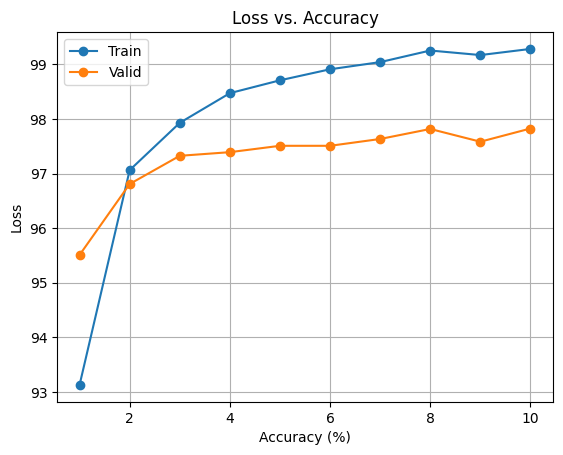

In [13]:
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()

# 그래프 2: 손실 vs. 정확도
plt.figure()
plt.plot(range(1, num_epochs+1), train_accuracies, 'o-', label='Train')
plt.plot(range(1, num_epochs+1), valid_accuracies, 'o-', label='Valid')
plt.xlabel('Accuracy (%)')
plt.ylabel('Loss')
plt.title('Loss vs. Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
from tqdm import tqdm
import time

# 진행 상태를 업데이트하는 예시
with tqdm(total=10, desc="Progress") as pbar:
    for i in range(10):
        time.sleep(0.5)
        pbar.update(1)

    # 진행 바 끝날 때 메시지 수정
    pbar.set_postfix_str("Done!")

Progress: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s, Done!]
